# spaTrack's multiple origins processing

In [3]:
import sys
sys.path.append('/Users/yzf/Desktop/spaTrack/')

This notebook uses the ICC data to show how spaTrack handles when data has multiple origins.

In [4]:
import spaTrack as spt
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0
plt.rcParams['figure.dpi'] = 200 #分辨率

Import the ICC data. 

In [6]:
adata = sc.read("/Users/yzf/Desktop/220808_streamplot/data/ICC/origin.exp.tsv", cache=True)
anno = pd.read_table("/Users/yzf/Desktop/220808_streamplot/data/ICC/origin.exp.annot.tsv")

adata.obs.index = anno["ID"].values
adata.obs["cluster"] = anno["cluster"].values
adata.obsm["X_spatial"] = anno[["X", "Y"]].values


Do the basic preprocessing and then visualize based on spatial information.

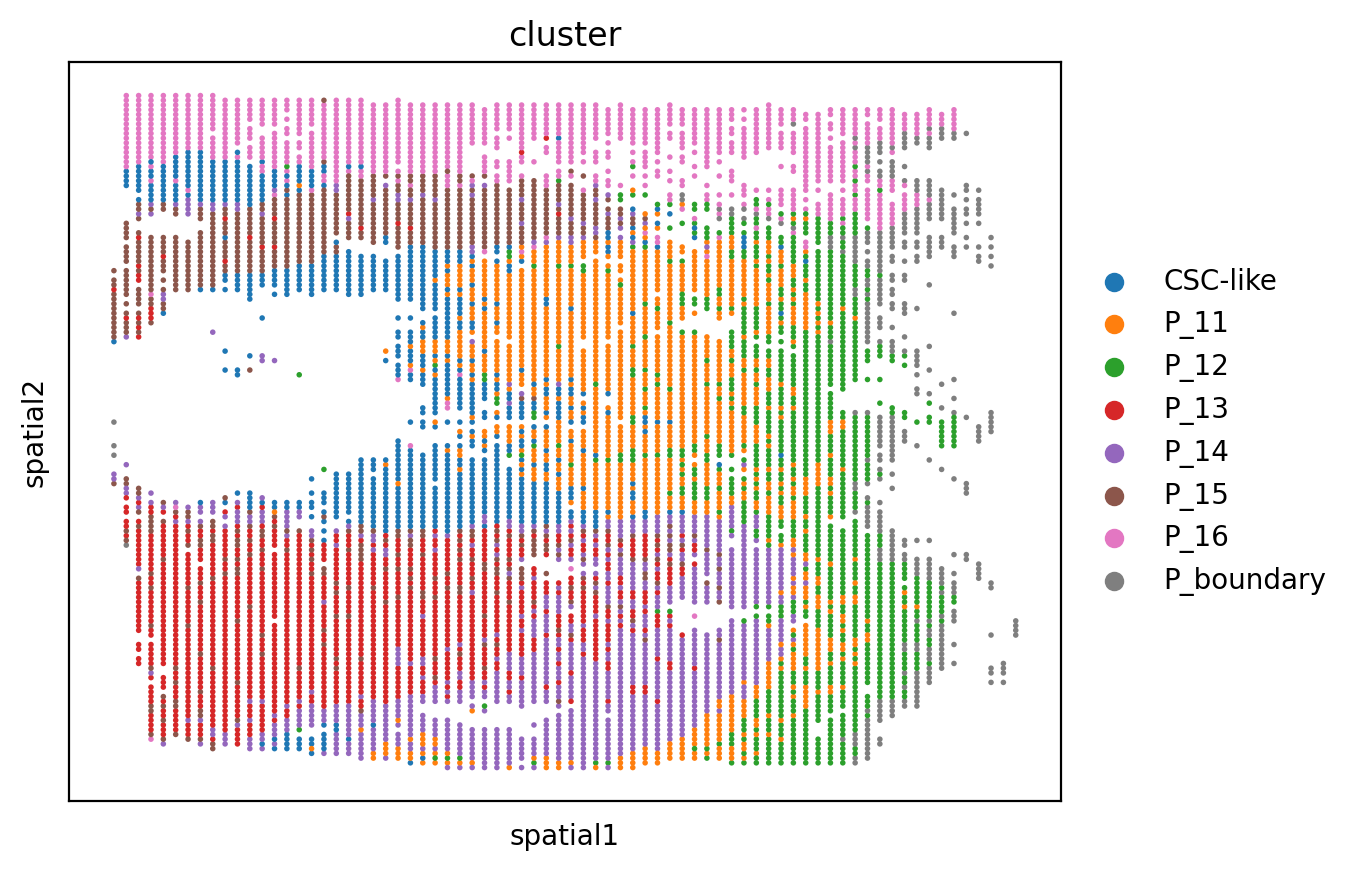

In [7]:
sc.pp.filter_genes(adata,min_cells=3)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

adata.obs = adata.obs.replace('CSC-like Tumor','CSC-like')
adata.obs = adata.obs.replace('T_boundary','T_border')

sc.pl.embedding(adata,basis='spatial',color='cluster')

## Compute the trajectory velocity

Now, we start to calculate the trajectory velocity.

First, the cell transition probability matrix is calculated through the optiml transport theory. A 'N x N'(N is the cell number) matrix will be generated. 

There are two modes of 'single-cell' and 'spatial'. In spatial mode, cell spatial position information will be additionally utilized.

In [8]:
adata.obsp['trans']=spt.get_ot_matrix(adata,data_type='spatial')

X_pca is not in adata.obsm, automatically do PCA first.


Now we will decide the starting cells.

According to prior knowledge, the starting cluster of iCAF data is the iCAF_PI16 cluster. However, in the visualization results, we can see that this type of cells are distributed in different positions. If you simply select the entire cluster, the result will be inaccurate. Here, the kmeans method is used to find the aggregation points of the cells in the cluster and the neighbor cells are taken as the starting cells.

kmean cluster centers:
[ 2800.48780488 10413.65853659]
[ 2378.78787879 14230.68181818]
[1654.16666667 4750.        ]
[  861.47540984 16625.40983607]


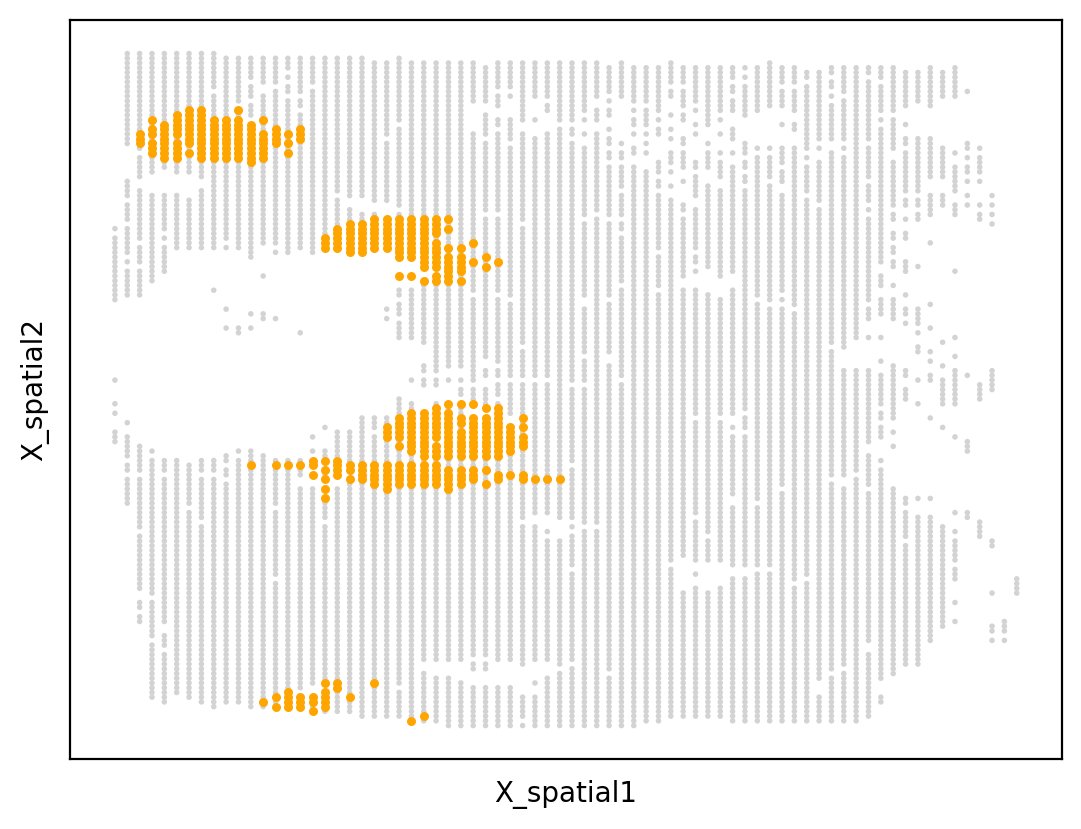

In [10]:
start_cells=spt.set_start_cells(adata,select_way='cell_type',partition=True,cell_type='CSC-like',n_neigh=100,n_clusters=4)

start_points = sc.pl.embedding(adata, basis='X_spatial',show=False)
points = adata.obsm['X_spatial'][start_cells]
start_points.scatter(points[:, 0], points[:, 1], s=5, color='orange')

Infer the cell pseudotime based on the OT matrix and start cells. 

In [11]:
adata.obs['ptime']=spt.get_ptime(adata,start_cells)

Calculate the vector field velocity. 

An important factor for cell velocity is cell neighbor selection. Neighbors can be selected in terms of cell Coordinates or gene expression, corresponding to 'n_neigh_pos' and 'n_neigh_gene' respectively. Coordinate neighbors are determined by KNN and gene neighbors are determined by Euclidean distance between cell expression. Then the intersection of coordinates neighbors and embedding matrix neighbors were used as final neighbors of each spot.

Then use the direction of the cell pointing to the neighbor as the speed direction (pseudo-timing determines whether the direction is reversed), the transition probability of the cell and its neighbors as the speed, and take the average as the final speed.

Finally, cell velocities are converted to grid velocities using the distance of the cells from the grid as weights. The visualization of vector field was adapted from sctour (Li, 2022).

In [12]:
adata.uns['E_grid'],adata.uns['V_grid']=spt.get_velocity(adata,basis='spatial',n_neigh_pos=100,n_neigh_gene=0)

Display the spatial information of cells, starting cells, the cell pseudotime and the inferred cell trajectory respectively.

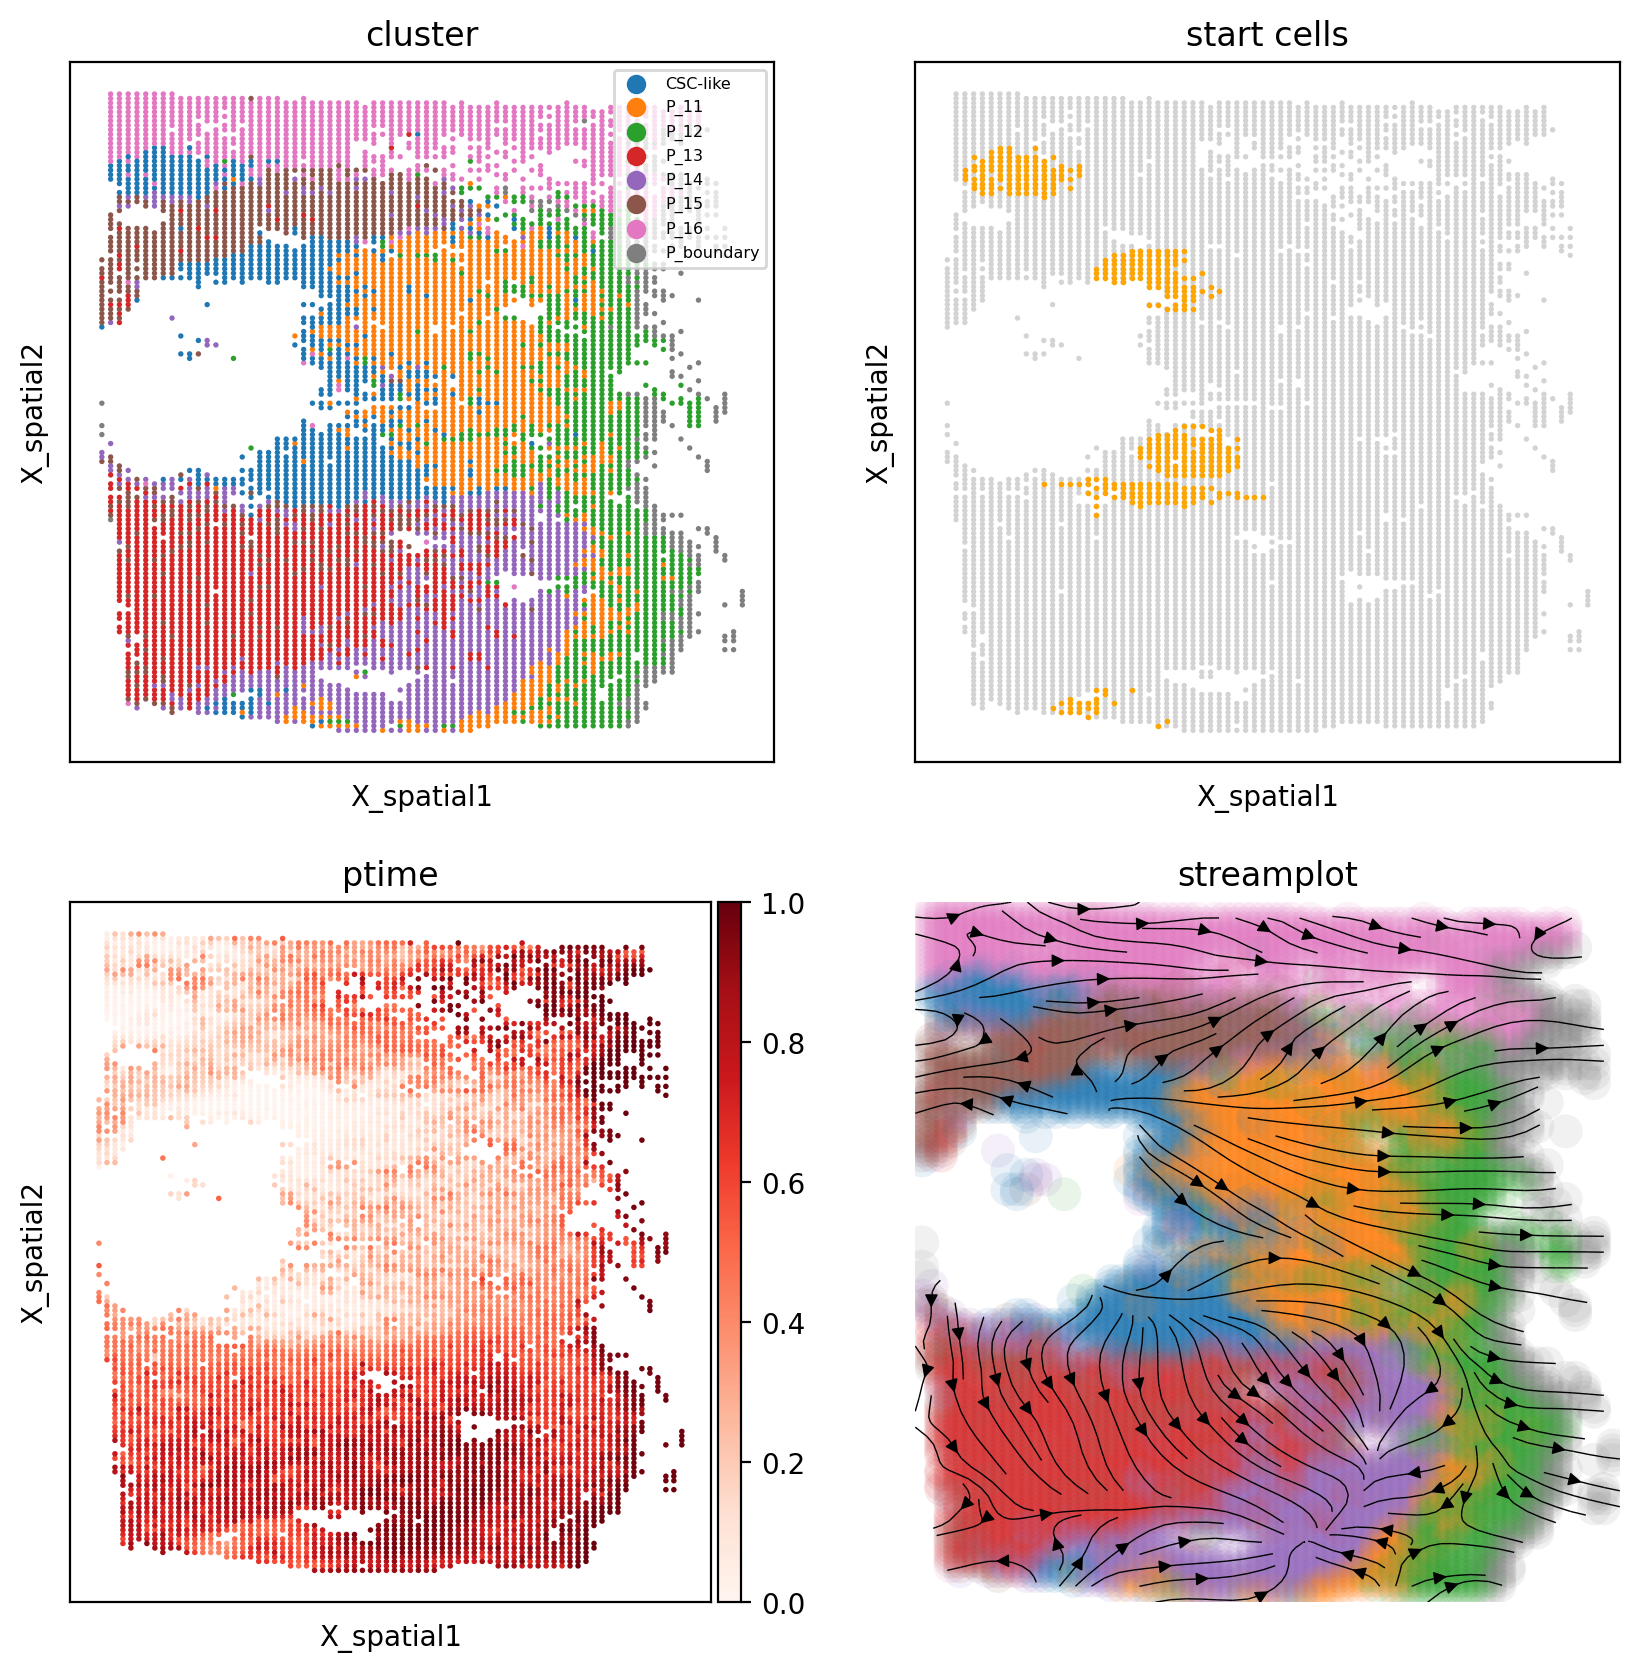

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
sc.pl.embedding(adata, basis='X_spatial', color='cluster', size=20, ax=axs[0][0], show=False,s=15)
axs[0][0].legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),fontsize='xx-small')

start_points = sc.pl.embedding(adata, basis='X_spatial',ax=axs[0][1], show=False, title='start cells',s=15)
points = adata.obsm['X_spatial'][start_cells]
start_points.scatter(points[:, 0], points[:, 1], s=1, color='orange')

sc.pl.embedding(adata, basis='X_spatial', color='ptime', show=False, ax=axs[1][0], color_map='Reds', title='ptime')

vf_velocity = sc.pl.embedding(adata, basis='X_spatial', show=False, ax=axs[1][1],color='cluster', legend_loc=None, frameon=False, title='streamplot', alpha=0.1, size=600)
vf_velocity.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1], color='black', linewidth=0.5,density=1.5)

## Key gene capture along the least action path

After completing the inference of the cell trajectory, we hope to find some cells on one trajectory in the vector field and check the changes of key genes between cells. In order to find the trajectory that best fits the vector field, we refer to the calculation of the least action path in dynamo.

First we need to reconstruct the vector field function. Here, Cell velocities are determined by each cell's predicted future state and current state, and we assume cell velocities can be sampled from a smooth, differentiable vector field function. Afterwards, we can predict the estimated cell velocity over the unsampled regions by the vector field function.

In [14]:
VecFld=spt.VectorField(adata,basis='spatial')

Select the start point and the end point of the least action path.

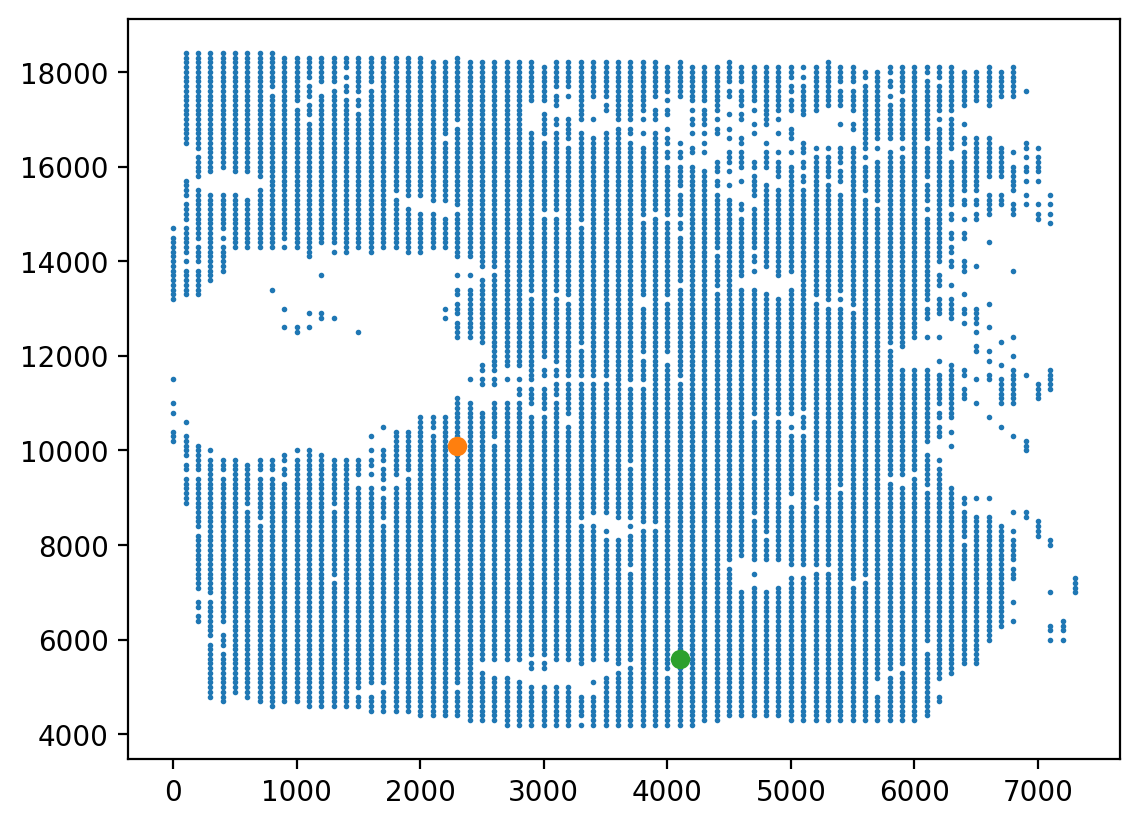

In [15]:
LAP_start_point=[2300,10100]
LAP_end_point=[4100,5650]

LAP_start_cell=spt.nearest_neighbors(LAP_start_point,adata.obsm['X_spatial'])[0][0]
LAP_end_cell=spt.nearest_neighbors(LAP_end_point,adata.obsm['X_spatial'])[0][0]

plt.scatter(*adata.obsm["X_spatial"].T,s=1)
plt.scatter(*adata[LAP_start_cell].obsm['X_spatial'].T)
plt.scatter(*adata[LAP_end_cell].obsm['X_spatial'].T)

Obtain the neighbor map according to the spatial location.

In [21]:
sc.pp.neighbors(adata,use_rep='X_spatial',key_added='X_spatial',n_neighbors=100)

Calculate the least action path between given start cells and end cells. The path can be made to fit the vector field better by adjusting the number of steps of the Expectation-maximization algorithm.

In [16]:
lap=spt.least_action(adata,
    init_cells=adata.obs_names[LAP_start_cell],
    target_cells=adata.obs_names[LAP_end_cell],
    vecfld=VecFld,
    basis='spatial',
    adj_key='X_spatial_distances',
    EM_steps=30,
    n_points=28
)

Plot the least action Path.

<AxesSubplot: title={'center': 'least action path'}, xlabel='X_spatial1', ylabel='X_spatial2'>

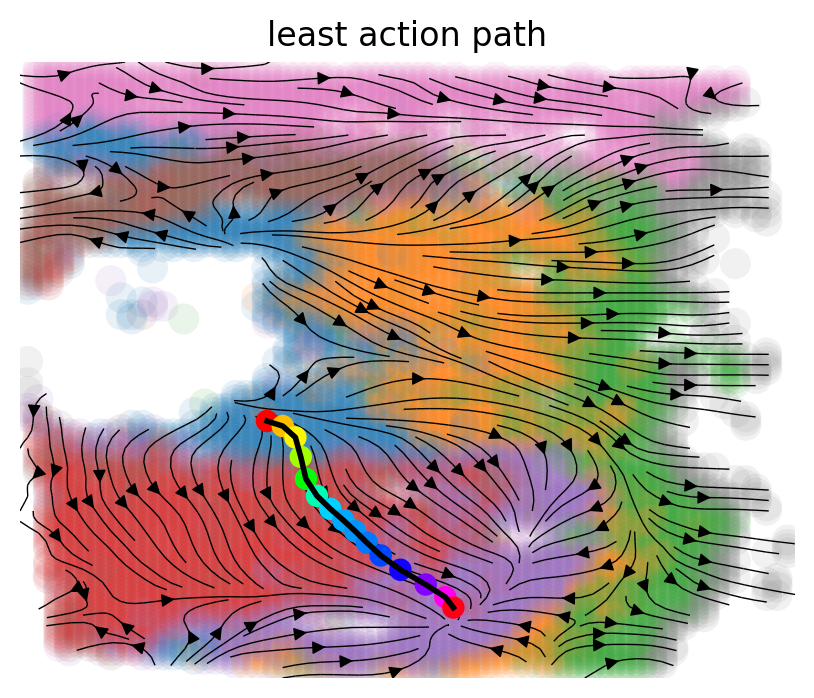

In [21]:
fig, ax = plt.subplots(figsize=(5, 4))
ax = sc.pl.embedding(adata, basis='X_spatial',show=False, ax=ax,color='cluster', legend_loc=None,legend_fontoutline=2 ,frameon=False, title='least action path', alpha=0.1, size=500)
ax.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1], density=2, color='black', linewidth=0.5)
spt.plot_least_action_path(adata,basis='spatial',ax=ax,linewidth=2,point_size=50)

Select neighbor cells around the least action path. And then map cells onto LAP pathways to give cells new ptimes to facilitate subsequent key gene sequencing.

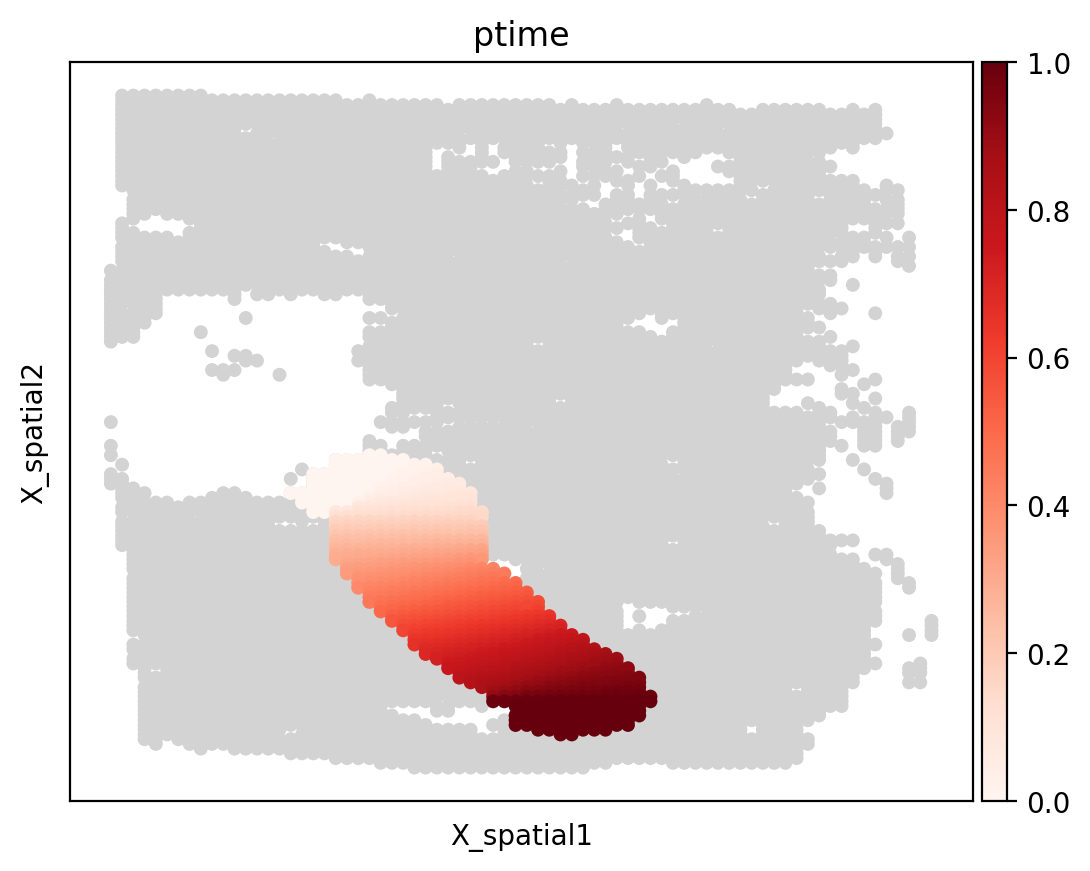

In [22]:
LAP_ptime,LAP_nbrs=spt.map_cell_to_LAP(adata)
sub_adata=adata[LAP_nbrs,:]
sub_adata.obs['ptime']=LAP_ptime
sub_adata=sub_adata[np.argsort(sub_adata.obs["ptime"].values), :].copy()

ax = sc.pl.embedding(adata, basis='X_spatial',show=False,size=100)
sc.pl.embedding(sub_adata, basis='X_spatial',ax=ax, color="ptime", cmap="Reds", size=100)

Limit cells to the few types of cells you want to observe.

In [23]:
sub_adata=sub_adata[sub_adata.obs['cluster'].isin(['CSC-like','P_13', 'P_14'])]

Filter genes based on the cell number and differential expression.

In [ ]:
sub_adata=spt.filter_gene(sub_adata,min_exp_prop=0.3,hvg_gene=2000)

cluter ordered by ptime :  ['CSC-like', 'P_13', 'P_14']
Cell number	748
Gene number	1884


Use generalized additive model to calculate time-to-gene correlations. Then use model fitness and FDR(false discovery rate) to select key genes. Finally, gene ranking is performed according to the differential genes of different clusters

In [31]:
df_res  = spt.ptime_gene_GAM(sub_adata,core_number=5)
df_sig_res = df_res.loc[(df_res['model_fit']>0.1) & (df_res['fdr']<0.05)]
sort_exp_sig = spt.order_trajectory_genes(sub_adata,df_sig_res,cell_number=20)

Genes number fitted by GAM model:   1884
Finally selected 209 genes.


Use heatmap to display key genes associated with ptime.

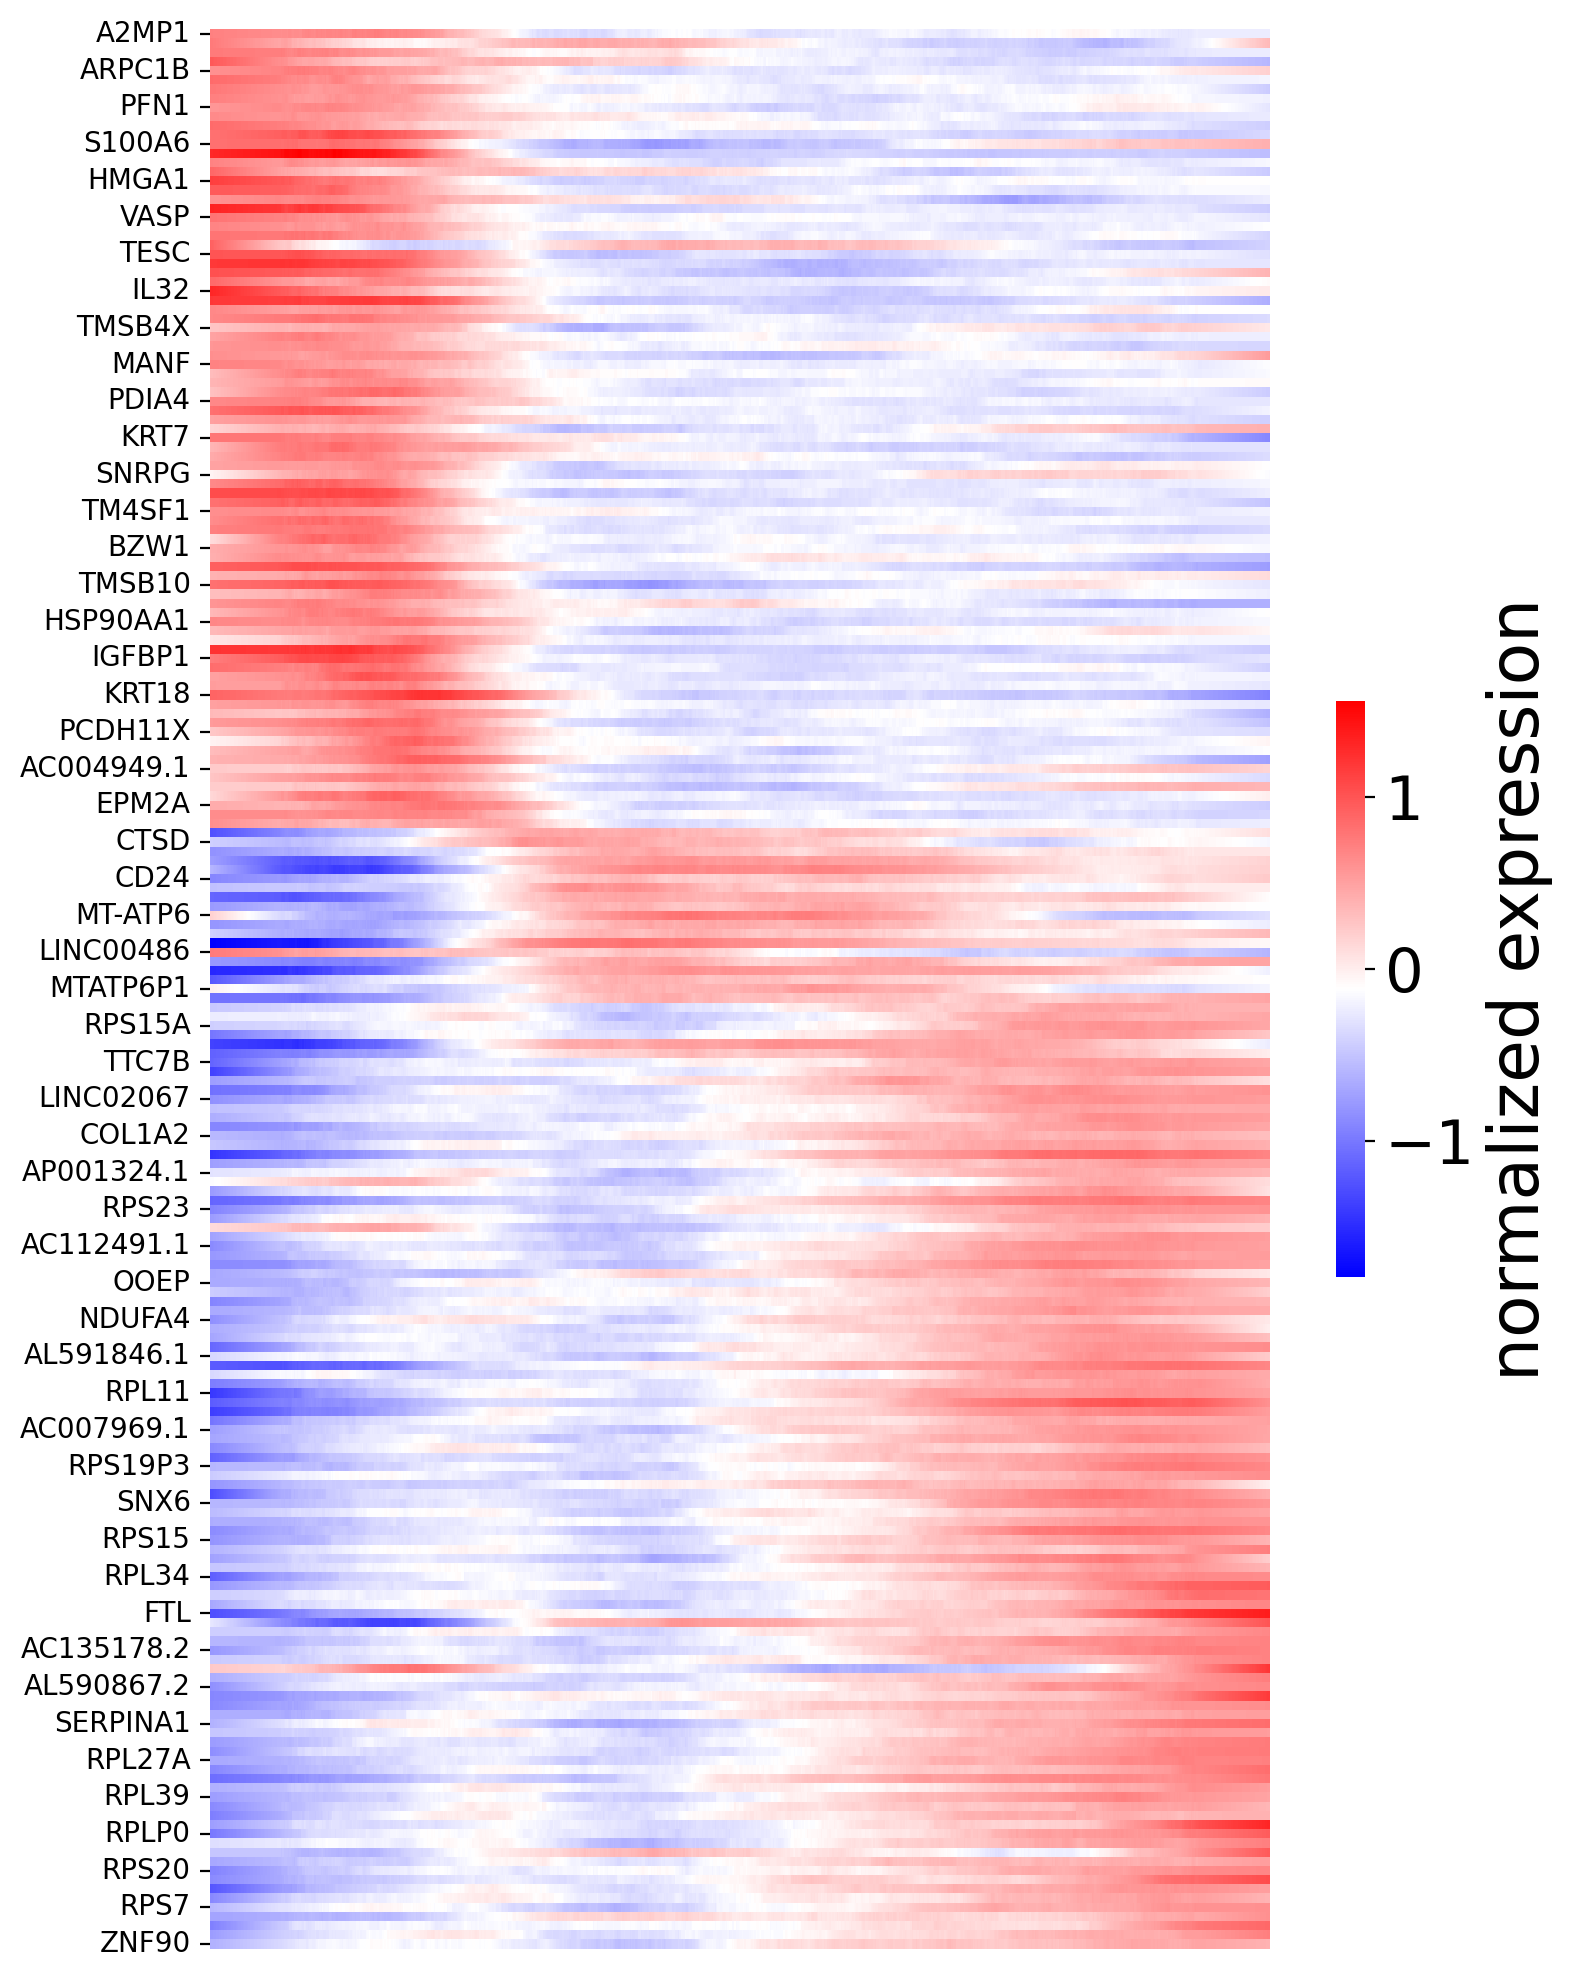

In [34]:
spt.plot_trajectory_gene_heatmap(sort_exp_sig,smooth_length=100,gene_label_size=10,cmap_name='bwr')

Use scatterplots to observe the expression of a single key gene at different ptimes.

<AxesSubplot: title={'center': 'RPL11'}, xlabel='ptime', ylabel='expression'>

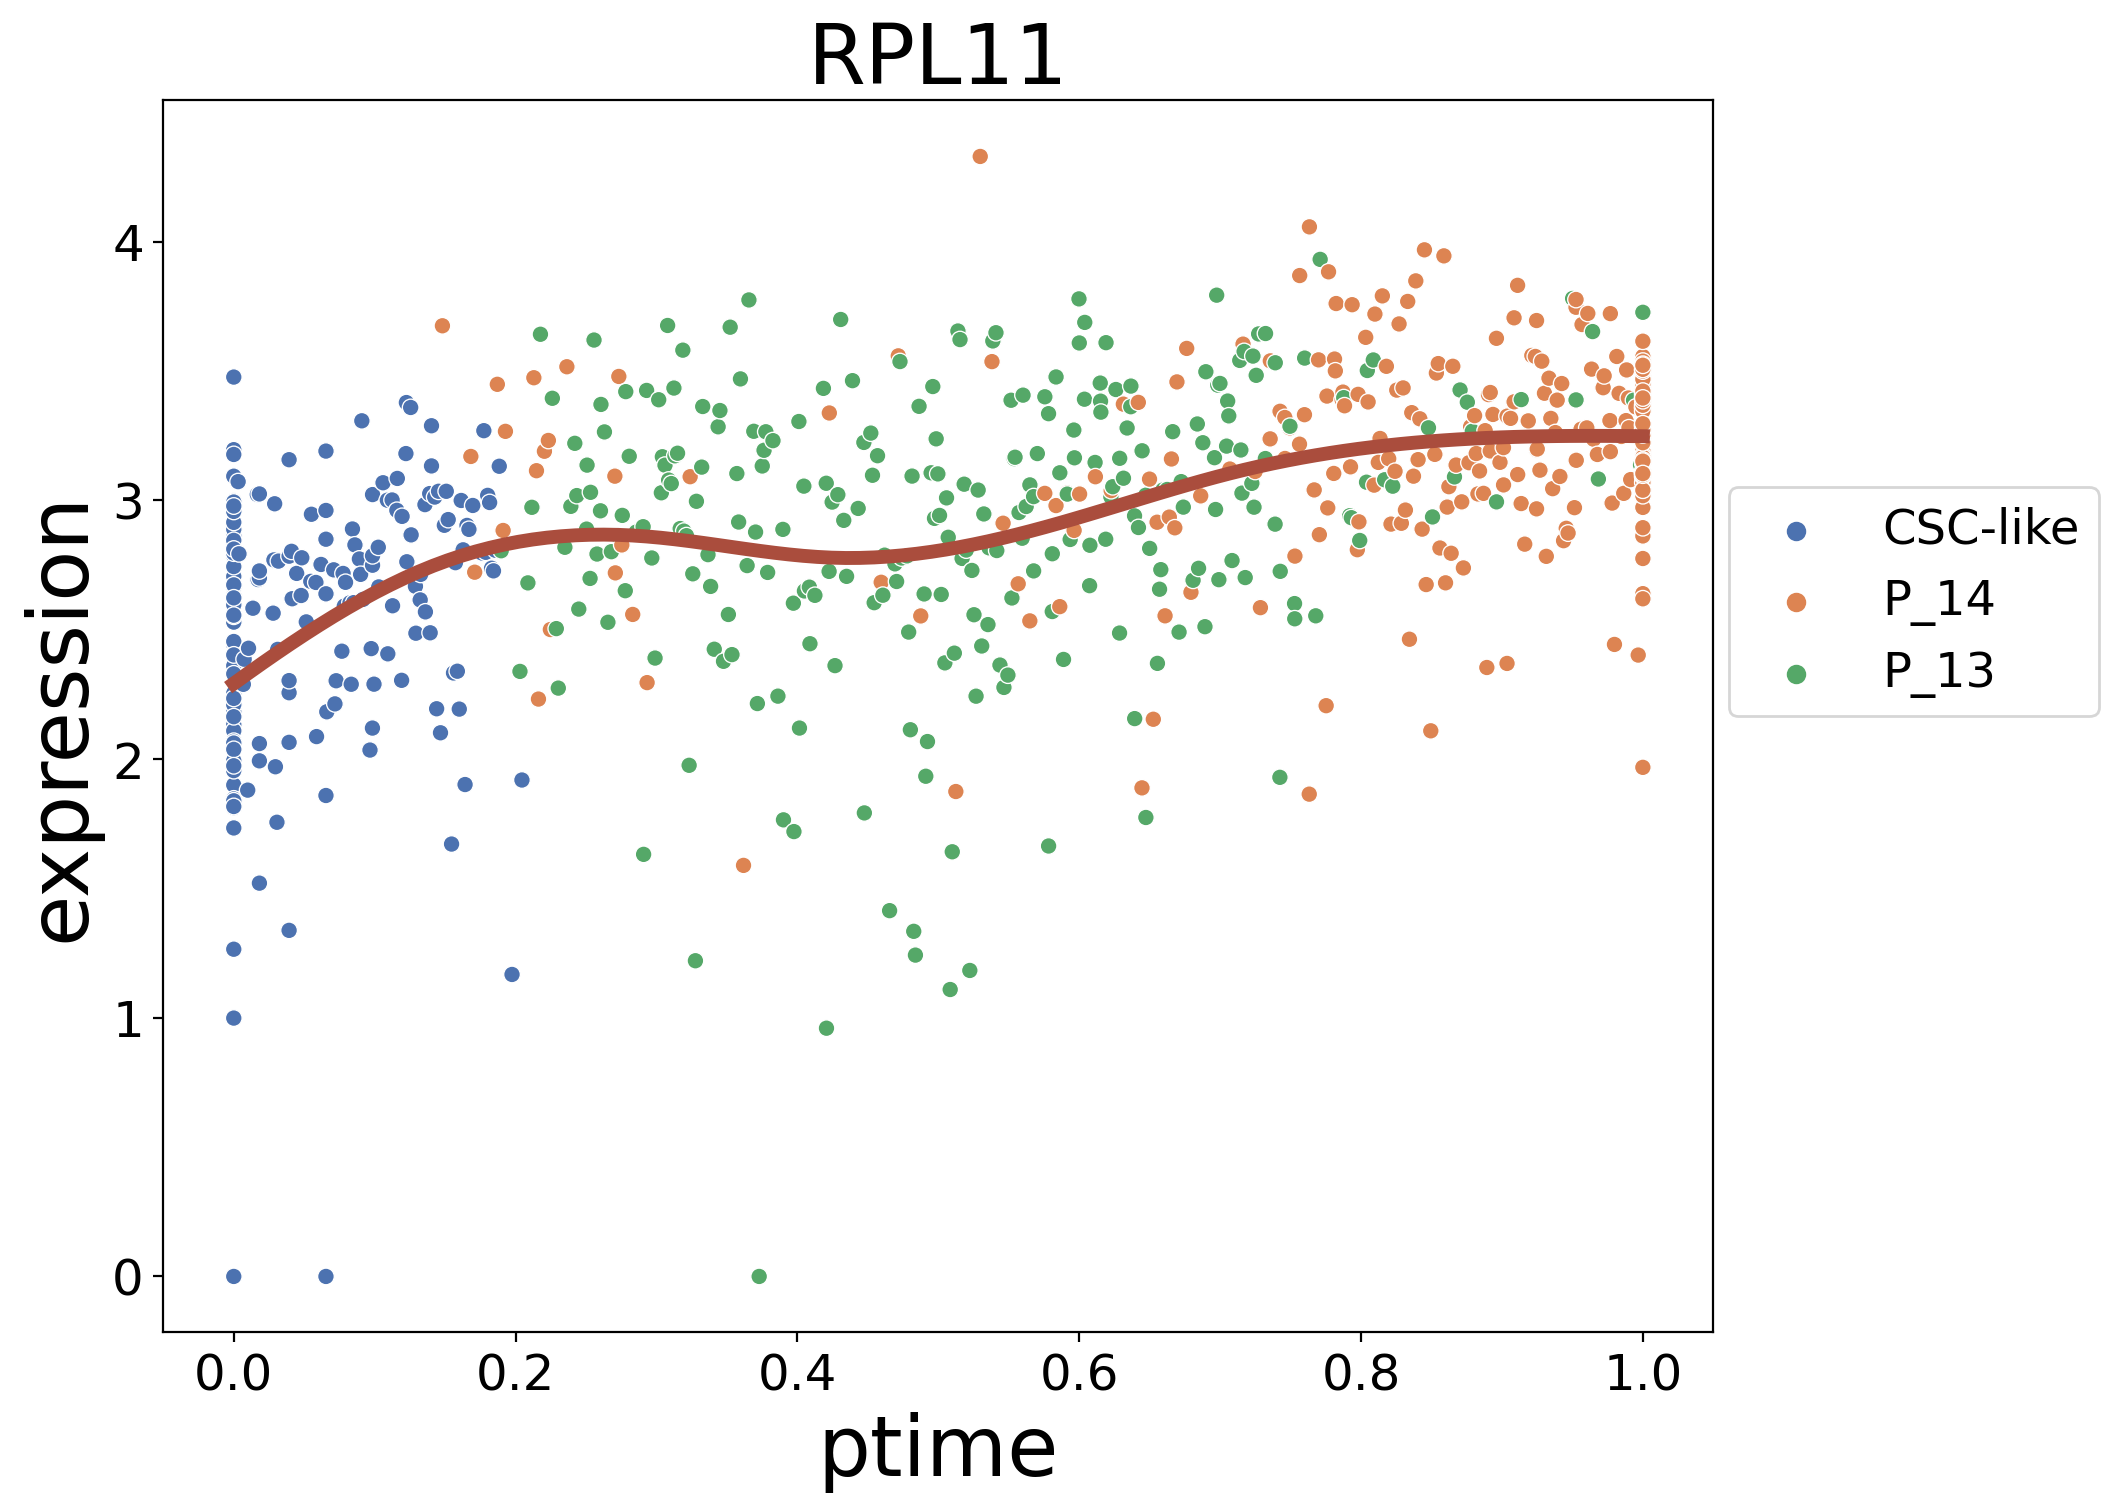

In [41]:
spt.plot_trajectory_gene(sub_adata,gene_name='RPL11',show_cell_type=True)